In [65]:
#
#Load the libaries
#
import pandas as pd                                   #Pandas
import matplotlib.pyplot as plt                       #matplotlib
import numpy as np                                    #numpy
import matplotlib.dates as mdates                     #dates stuff

# Set the canvas size so the plots can be seen
plt.rcParams['figure.figsize'] = [15, 15]

In [67]:
import requests                   # Library for requests
from bs4 import BeautifulSoup     # BS library

# setup the array for the stock listing
stockListingArray = []

#
#   URL:    https://www.morningstar.co.uk/uk/news/180953/5-uk-stocks-on-the-global-income-bellwether-list.aspx
#   
#   This URL lists the top five bellwether stocks from the london stock exchange
#
#   Using Scraping looking for a combinaton of html tags (as listed below) to get 
#   the character id of the stock exchange listing. It is noted that the html 
#   is not tagged with specific IDs
#
#   <h3>
#       <strong>
#           <a>
#
#   The stock ID is the text for the anchor html tag (<a>)
#

# set the URL
URL = "https://www.morningstar.co.uk/uk/news/180953/5-uk-stocks-on-the-global-income-bellwether-list.aspx"

# Load the Page
page = requests.get(URL)

# Process the page using beautiful soup
soup = BeautifulSoup(page.content, "html.parser")

# Html Elements
HTMLElementsH3 = soup.find_all("h3" )
for HTMLElements in HTMLElementsH3:
    HTMLElementsStrong = HTMLElements.find("strong")
    if ( HTMLElementsStrong != 'None'):
        HTMLElementsAnchor = HTMLElementsStrong.find("a")
        if ( HTMLElementsAnchor != 'None'):
            #print(HTMLElementsAnchor.prettify())
            # grab the text of the anchor and replace and dots ("."). 
            # Also need to add ".XLON" to the text.
            HTMLElementsAnchor = HTMLElementsAnchor.contents[0].replace(".", "")+'.XLON'
            stockListingArray.append (HTMLElementsAnchor)

#
#   URL:    https://www.dividend.com/how-to-invest/5-stocks-that-are-bellwethers-for-the-u-s-economy/
#   
#   This URL lists the top five bellwether stocks from the NYSE stock exchange
#
#   Using scraping looking for a combinaton of html tags (as listed below) to get 
#   the character id of the stock exchange listing. It is noted that the html 
#   is not tagged with specific IDs
#
#   <h2 class="n-text__section_heading t-text-gray-725">
#
#   The stock ID is the text for the header2 tag <h2>
#

# set the URL
URL = "https://www.dividend.com/how-to-invest/5-stocks-that-are-bellwethers-for-the-u-s-economy/"

# Load the Page
page = requests.get(URL)

# Process the page using beautiful soup
soup = BeautifulSoup(page.content, "html.parser")

# Html Elements
HTMLElementsH2 = soup.find_all("h2", class_="n-text__section_heading t-text-gray-725" )
for HTMLElements in HTMLElementsH2:
    HTMLElements = HTMLElements.contents[0]
    #print (HTMLElements)
    st = HTMLElements.find ("(")
    if ( st != -1 ) :
        en = HTMLElements.find(")")
        if ( en != -1 ):
            stockListingArray.append (HTMLElements[(st+1):(en)].strip())

print (stockListingArray)

# store the list of targeted stock listings as a file called target.csv
stockListingArrayDF = pd.DataFrame(stockListingArray)
stockListingArrayDF.to_csv( '../Data/targetStocks.csv', encoding='utf-8', header=False )


['BP.XLON', 'BATS.XLON', 'DGE.XLON', 'HSBA.XLON', 'ULVR.XLON', 'FDX', 'AA', 'LVMUY', 'CAT', 'WMT']


In [70]:
import json		         # library for the JSON string processing. 


# Call to the marketstack API to get the list of tickers. The URL for the API 
# is made up of the following pieces
#	Website:	http://api.marketstack.com/v1/
#	Service:	tickers
#	access_key:	Access key for accessing the API
#	limit:		The number of records. The value was set to 204799 but the API 
#               only return 10000 records.	

URLbase = 'http://api.marketstack.com/v1/tickers'
access_key = 'access_key=e4e46efde92ca49b01d6df5955a48c6d'
limit = '&limit=204799'

# create the URL for the API
URL = URLbase+"?"+access_key+limit

# Make the API call. This returns a JSON object
tickersResponseFromAPI = requests.get('http://api.marketstack.com/v1/tickers?access_key=e4e46efde92ca49b01d6df5955a48c6d&limit=204799')
print (tickersResponseFromAPI.text)

# Process the JSON output text from the API and convert to a Dictionary. There 
# are two main parts in the JSON structure: Pagination (overall detail of 
# response) and Data.
tickersDICT = json.loads(tickersResponseFromAPI.text)
print ( tickersDICT.keys() )

# Convert the dictionary into a dataframe and examine the data.
tickersDF = pd.DataFrame.from_dict( tickersDICT['data'] )
tickersDF.info()
tickersDF.shape
tickersDF.head()

# Output the data to a CSV file called 'tickers.csv' in the Data folder
#dataDF.to_csv('../Data/tickers.csv', encoding='utf-8')

# The data has two fields which characterise the type of stock data available.
#   has_intraDay    indicates (when true) the if stock data information is recorded 
#                   during the day
#   has_eod         indicates (when true) the if stock data information is recorded 
#                   at the end of the day
#
# Foe the analysis, we will concentrate only on the has_eod==true and the 
# has_intraday == false
   
print ("Examing 'has_intraday'")
print ('Has_intraday==false shape is : '+str(tickersDF[tickersDF['has_intraday'] == False].shape))
print ('Has_intraday==true shape is : '+str(tickersDF[tickersDF['has_intraday'] == True].shape))

print ("Examing 'has_eod'")
print ('Has_eod==false shape is : '+str(tickersDF[tickersDF['has_eod'] == False].shape))
print ('Has_eod==false shape is : '+str(tickersDF[tickersDF['has_eod'] == True].shape))

# include the records noted above
tickersDF = tickersDF[(tickersDF['has_intraday'] == False) & (tickersDF['has_eod'] == True)]

# Create a field called 'acronym' and set the value to the 'acronym' in the 
# data dictionary in 'stock_exchange'
tickersDF['acronym'] = [ d.get('acronym') for d in tickersDF['stock_exchange']]

# fix the blanks in 'acronym' where the OTC (over the counter) values are left
# blank.
tickersDF.loc[tickersDF['acronym']=='','acronym'] = 'OTC'

# Update the field called 'country' and set the value to the 'country' in the 
# data dictionary in 'stock_exchange'
tickersDF['country'] = [ d.get('country') for d in tickersDF['stock_exchange']]

# Create a field called 'country_code' and set the value to the 'countryCode' in the 
# data dictionary in 'stock_exchange'
tickersDF['country_code'] = [ d.get('country_code') for d in tickersDF['stock_exchange']]

# Create a field called 'city' and set the value to the 'countryCode' in the 
# data dictionary in 'stock_exchange'
tickersDF['city'] = [ d.get('city') for d in tickersDF['stock_exchange']]

print ( tickersDF.head() )

# drop the 'stock_exchange' columns
tickersDF = tickersDF.drop('stock_exchange', axis=1)

print (tickersDF.info())
print (tickersDF.head())

# Write the dataframe to the tickers2.csv
tickersDF.to_csv( '../Data/Tickers.csv', encoding='utf-8' )

{"error":{"code":"usage_limit_reached","message":"Your monthly usage limit has been reached. Please upgrade your Subscription Plan."}}
dict_keys(['error'])


KeyError: 'data'

In [71]:
# Read in the list of tickers from 'tickers2.csv'
tickersDF = pd.read_csv('../Data/tickers.csv', index_col='symbol')
print ( tickersDF.info() )
print ( tickersDF.head() )

# Read in the list of targeted stocks from 'targetStocks.csv'. 
# The file does not have columnsNames so the column names will be set as part
# of the import. 
columnNames = ['index', 'stock']
targetStocksDF = pd.read_csv('../Data/targetStocks.csv', names=columnNames, header=None, index_col='index')

# Just use the 'stock' column
targetStocksDF = targetStocksDF.loc[:,['stock']]
print ( targetStocksDF.info() )
print ( targetStocksDF.head(10) )

# create 'targetTickersDF' which will contain the records in 'tickersDF' which
# have a symbol in 'targetStocksDF'. 
targetTickersDF = tickersDF[tickersDF.index.isin(targetStocksDF['stock'])]
print ( targetTickersDF )

# Create an array doe filenames
fileNameListArray = []

# Now need to extract the data via the API. To do this we are going to extract
# the data for each of the targeted tickers.

limit = '&limit=10000'
access_key = 'access_key=e4e46efde92ca49b01d6df5955a48c6d'
URLbase = 'http://api.marketstack.com/v1/eod'


for index, specificTicker in targetTickersDF.iterrows():
    
    # Call to the marketstack API to get the list of tickers. The URL for the 
    # API is made up of the following pieces
    #
    #	Website:	http://api.marketstack.com/v1/
    #	Service:	eod (end of day)
    #	access_key:	Access key for accessing the API
    #   symbols:    The specific symbol (tickers) being downloaded
    #   exchange:   THe exchange where the ticker can be found
    #   date_from:  the start date of the request
    #   date_tp:    The end date of the request 
    #	limit:		The number of records. (set to 10000)
    
    # Create the URL using URLbase
    URLstart = URLbase + "?"+access_key
    URLstart = URLstart + '&symbols='+index
    URLstart = URLstart + '&exchange='+specificTicker.loc['acronym']
    URLstart = URLstart + limit
    URL = URLstart + '&date_from=2019-01-01'
    URL = URL + '&date_to=2022-12-31'

    # Make the API call. This returns a JSON object
    tickers_response_from_API = requests.get(URL)
    
    # turn the JSON object into a dictionary. The Json object has two 
    # significant parts 1) the Pagination which describes information on the 
    # response and the 2) the data which holds the data.
    tickersDataDICT = json.loads(tickers_response_from_API.text)
    #print ( tickersDataDICT.keys() )
    
    # create a dataframe using the data portion of the dictionary
    tickersDataDF = pd.DataFrame.from_dict( tickersDataDICT['data'] )
    
    # create a file with a name in the format <folder>+"tickers-"<symbol>".csv"
    filename = '../Data/stock-data-'+index+".csv"
    #print ( filename )
    tickersDataDF.to_csv(filename, encoding='utf-8')

    #maintain a list of files
    fileNameListArray.append (filename)

# output the list of files into a file called MasterFIleList.csv
print (fileNameListArray)
fileNameListDF = pd.DataFrame (fileNameListArray)
fileNameListDF.to_csv('../Data/MasterFileList.csv', encoding='utf-8', header=False )

<class 'pandas.core.frame.DataFrame'>
Index: 8700 entries, MSFT to MN
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    8700 non-null   int64 
 1   name          8688 non-null   object
 2   has_intraday  8700 non-null   bool  
 3   has_eod       8700 non-null   bool  
 4   country       8700 non-null   object
 5   acronym       8700 non-null   object
 6   country_code  8700 non-null   object
 7   city          8700 non-null   object
dtypes: bool(2), int64(1), object(5)
memory usage: 492.8+ KB
None
        Unnamed: 0                    name  has_intraday  has_eod country  \
symbol                                                                      
MSFT             0   Microsoft Corporation         False     True     USA   
AAPL             1               Apple Inc         False     True     USA   
AMZN             2          Amazon.com Inc         False     True     USA   
GOOG             3  Alphabe

KeyError: 'data'

In [72]:
# Read in the list of tickers from 'masterFIleList.csv'
colNames = ['index','filename']
fileListDF = pd.read_csv('../Data/MasterFileList.csv', names=colNames)
print ( fileListDF.info() )
print ( fileListDF.head(10) )

# load the first datafile into the dataframe.
print (fileListDF.loc[0,'filename'])
masterDF = pd.read_csv (fileListDF.loc[0,'filename'], parse_dates=(['date']), index_col=['symbol','date'])
print ( masterDF.info() )
print ( masterDF.head(10) )

# now remove the first record from the fileListDF so that we do not use it 
# again
fileListDF = fileListDF.loc[1:,'filename']

# iterate through the remaining files, loading each one, one at a time. Once 
# the file is loaded, it is concatenated on to master DF
for filename in fileListDF:
    
    currentDF = pd.read_csv (filename, parse_dates=(['date']), index_col=['symbol','date'])
    masterDF = pd.concat ([masterDF, currentDF])

#Examine 
print (masterDF.shape)
print ( masterDF.info() )

masterDF.to_csv ('../Data/masterData.csv', encoding='utf-8' )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     9 non-null      int64 
 1   filename  9 non-null      object
dtypes: int64(1), object(1)
memory usage: 272.0+ bytes
None
   index                          filename
0      0        ../Data/stock-data-WMT.csv
1      1        ../Data/stock-data-CAT.csv
2      2  ../Data/stock-data-ULVR.XLON.csv
3      3  ../Data/stock-data-HSBA.XLON.csv
4      4    ../Data/stock-data-BP.XLON.csv
5      5  ../Data/stock-data-BATS.XLON.csv
6      6   ../Data/stock-data-DGE.XLON.csv
7      7        ../Data/stock-data-FDX.csv
8      8         ../Data/stock-data-AA.csv
../Data/stock-data-WMT.csv
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 198 entries, ('WMT', Timestamp('2022-12-30 00:00:00+0000', tz='UTC')) to ('WMT', Timestamp('2022-03-21 00:00:00+0000', tz='UTC'))
Data columns (total 14 columns):
 #   Column       

In [73]:
# List of NYSE stock exchange symbols (note one symbol is missing )
NYSE = ['AA','CAT','FDX','WMT']

# List of LSD stock exchange symbols 
LSE = ['BATS.XLON','BP.XLON','DGE.XLON','HSBA.XLON','ULVR.XLON']

# Read the data in from the CSV file and check the input
masterDF = pd.read_csv ('../Data/masterData.csv', parse_dates=(['date']), index_col=['date','symbol'])
masterDF.info()
masterDF.head()
masterDF.isna().any()

# examine the main data variables 
masterDF[['open','close','high', 'low']].head(20)

#concentrate on the closing prices for each day
closingOnlyDF = masterDF['close']

# reshape the data using unstack. this creates individual closing value columns for each symbol
closingOnlyDF = closingOnlyDF.unstack()
closingOnlyDF.info()

#make sure we do not have a time zone issue
closingOnlyDF.index = closingOnlyDF.index.date
closingOnlyDF.head()

# Cleanup the data and deal with the missing entries (NAN) by interpolating the data. the missing entries 
# relate to when the stock exchange is closed
closingOnlyDF = closingOnlyDF.reindex(pd.date_range(start=closingOnlyDF.index.min(), end=closingOnlyDF.index.max(),freq='1D'))
closingOnlyDF.sort_index(ascending=False).head(10)

# Use the pandas interpolation function to estimate the missing values. Use the "linear" method as it is not expected
# there would be much fluctuations in data over weekends and holidays,
closingOnlyDF = closingOnlyDF.interpolate(method='linear')
closingOnlyDF.info()
closingOnlyDF.head(10)

# create a new column for the NYSE and LSE containing the average value
# of the chosen stocks from those exchanges
closingOnlyDF['NYSE'] = closingOnlyDF[NYSE].mean(axis=1)
closingOnlyDF['LSE'] = closingOnlyDF[LSE].mean(axis=1)
closingOnlyDF.head()

# Add a column for the first quartile for the NYSE and LSE
closingOnlyDF['NYSEQ1'] = closingOnlyDF[NYSE].quantile(0.25, axis=1)
closingOnlyDF['LSEQ1'] = closingOnlyDF[LSE].quantile(0.25, axis=1)

# Add a column for the third quartile for the NYSE and LSE
closingOnlyDF['NYSEQ3'] = closingOnlyDF[NYSE].quantile(0.75, axis=1)
closingOnlyDF['LSEQ3'] = closingOnlyDF[LSE].quantile(0.75, axis=1)

closingOnlyDF.info()
closingOnlyDF.head()

# Store the closing dataframe as a CSV (this is a break point)
closingOnlyDF.index.name = 'Time'
closingOnlyDF.info()
closingOnlyDF.to_csv('../Data/closingData.csv', encoding='utf-8')



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1776 entries, (Timestamp('2022-12-30 00:00:00+0000', tz='UTC'), 'WMT') to (Timestamp('2022-03-21 00:00:00+0000', tz='UTC'), 'AA')
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1776 non-null   int64  
 1   open          1776 non-null   float64
 2   high          1776 non-null   float64
 3   low           1776 non-null   float64
 4   close         1776 non-null   float64
 5   volume        1776 non-null   float64
 6   adj_high      208 non-null    float64
 7   adj_low       208 non-null    float64
 8   adj_close     1776 non-null   float64
 9   adj_open      208 non-null    float64
 10  adj_volume    208 non-null    float64
 11  split_factor  1776 non-null   float64
 12  dividend      1776 non-null   float64
 13  exchange      1776 non-null   object 
dtypes: float64(12), int64(1), object(1)
memory usage: 209.6+ KB
<class 'pandas.core.frame.DataFram

In [74]:
# Read in teh GDP database and check that the data is okay. This analysis is only interested in four fields, 
# Time, LOCATION, Value and Variable and the remainder are ignored. The Time field is used as the Index
GDPDF = pd.read_csv ('../Data/GDP.csv', parse_dates=(['Time']), usecols=['Time','LOCATION','Value','VARIABLE'], index_col=['Time'])
GDPDF.info()
GDPDF.isna().any()
GDPDF.head(10)

# Check the 'VARIABLE' field
GDPDF.groupby('VARIABLE').count()

# Check the 'LOCATION' field
GDPDF.groupby('LOCATION').count()

#
#   USA GDP
#
# Create a new dataframe only containing data from 'USA' and only containing the Tracker_YOY values.
GDPDF_USA = pd.DataFrame(GDPDF[(GDPDF['LOCATION']=='USA') & (GDPDF['VARIABLE']=='TRACKER_YOY')]['Value']).sort_index()

# ensure we have rows for all dates in the time range by reindexing the data.
days = pd.date_range (freq="D", start=closingOnlyDF.index.min(), end=closingOnlyDF.index.max())
GDPDF_USA = pd.DataFrame(GDPDF_USA.reindex(days, method="nearest"))

# use the interpolate function to "fill in the blanks". Assumption (again) is that there are no significant fluctuations 
# in the missing data.
GDPDF_USA = GDPDF_USA.interpolate(method='linear')
GDPDF_USA.sort_index(ascending=False).head(10)

# Merge the data with the closingOnlyDF dataframe calling the resulting new field "USA_GDP"
closingOnlyDF = pd.merge ( closingOnlyDF, GDPDF_USA, left_index=True, right_index=True, how="left" )
closingOnlyDF.rename(columns={'Value': 'USA_GDP'}, inplace=True)
closingOnlyDF.info()

# Check how many blanks there are.
closingOnlyDF[closingOnlyDF['USA_GDP'].notna()].head(10)

#
#   GBR GDP
#
# Create a new dataframe only containing data from 'GBR' and only containing the Tracker_YOY values.
GDPDF_GB = pd.DataFrame(GDPDF[(GDPDF['LOCATION']=='GBR') & (GDPDF['VARIABLE']=='TRACKER_YOY')]['Value']).sort_index()

# ensure we have rows for all dates in the time range by reindexing the data.
GDPDF_GB = pd.DataFrame(GDPDF_GB.reindex(days, method="nearest"))

# use the interpolate function to "fill in the blanks". Assumption (again) is that there are no significant fluctuations 
# in the missing data.
GDPDF_GB = GDPDF_GB.interpolate(method='linear')
GDPDF_GB.sort_index(ascending=False).head(10)

# Merge the data with the closingOnlyDF dataframe calling the resulting new field "USA_GDP"
closingOnlyDF = pd.merge ( closingOnlyDF, GDPDF_GB, left_index=True, right_index=True, how="left" )
closingOnlyDF.rename(columns={'Value': 'GBR_GDP'}, inplace=True)
closingOnlyDF.info()

# Check how many blanks there are.
closingOnlyDF[closingOnlyDF['GBR_GDP'].notna()].head(10)

# Store the closing dataframe as a CSV (this is a break point)
closingOnlyDF.info()
closingOnlyDF.to_csv('../Data/closingDataGDP.csv', encoding='utf-8')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4266 entries, 2019-01-13 to 2023-01-08
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LOCATION  4266 non-null   object 
 1   VARIABLE  4266 non-null   object 
 2   Value     4266 non-null   float64
dtypes: float64(1), object(2)
memory usage: 133.3+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2022-03-21 to 2022-12-30
Freq: D
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AA         285 non-null    float64
 1   BATS.XLON  285 non-null    float64
 2   BP.XLON    285 non-null    float64
 3   CAT        285 non-null    float64
 4   DGE.XLON   285 non-null    float64
 5   FDX        285 non-null    float64
 6   HSBA.XLON  285 non-null    float64
 7   ULVR.XLON  285 non-null    float64
 8   WMT        285 non-null    float64
 9   NYSE       285 non-null    float64
 10  LSE       

In [76]:
# Read in the data from the closingData file
closingOnlyDF = pd.read_csv  ('../Data/closingDataGDP.csv', parse_dates=(['Time']), index_col=['Time'] )
closingOnlyDF.info()
closingOnlyDF.head(20)

# create a weekly date range for the time frame using Monday as the day in the week
weeks = pd.date_range (freq="W-MON", start=closingOnlyDF.index.min(), end=closingOnlyDF.index.max())

# Downsample the data from the daily data by reindexing using the weeklydates. 
ClosingOnlyWeeksMDF = pd.DataFrame(closingOnlyDF.reindex(weeks))
ClosingOnlyWeeksMDF.info()
ClosingOnlyWeeksMDF.head()

# determine the percentage change for each measurement compared to the following measurement (and multiply by 100)
# Note a NAN appears for the first value as there is no previous measurement.
ClosingOnlyWeeksMPCDF = ClosingOnlyWeeksMDF.pct_change().mul(100)
ClosingOnlyWeeksMPCDF.head()

# downsample the data from the daily data using the resample function and generate weekly data based on the mean
ClosingOnlyWeeksAvgDF = closingOnlyDF.resample("W").mean()
ClosingOnlyWeeksAvgDF.info()
ClosingOnlyWeeksAvgDF.head()

# determine the percentage change for each average measurement compared to the following measurement (and multiply by 100)
# Note a NAN appears for the first value as there is non previous measurement.
ClosingOnlyWeeksAvgPCDF = ClosingOnlyWeeksAvgDF.pct_change().mul(100)
ClosingOnlyWeeksAvgPCDF.head()

# Store the closing dataframe (based on Mondays) as a CSV (this is a break point)
ClosingOnlyWeeksMPCDF.index.name = 'Time'
ClosingOnlyWeeksMPCDF.info()
ClosingOnlyWeeksMPCDF.to_csv('../Data/weeklyClosingDataMonday.csv', encoding='utf-8')

# Store the closing dataframe (based on averages) as a CSV (this is a break point)
ClosingOnlyWeeksAvgPCDF.index.name = 'Time'
ClosingOnlyWeeksAvgPCDF.info()
ClosingOnlyWeeksAvgPCDF.to_csv('../Data/weeklyClosingDataAverage.csv', encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2022-03-21 to 2022-12-30
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AA         285 non-null    float64
 1   BATS.XLON  285 non-null    float64
 2   BP.XLON    285 non-null    float64
 3   CAT        285 non-null    float64
 4   DGE.XLON   285 non-null    float64
 5   FDX        285 non-null    float64
 6   HSBA.XLON  285 non-null    float64
 7   ULVR.XLON  285 non-null    float64
 8   WMT        285 non-null    float64
 9   NYSE       285 non-null    float64
 10  LSE        285 non-null    float64
 11  NYSEQ1     285 non-null    float64
 12  LSEQ1      285 non-null    float64
 13  NYSEQ3     285 non-null    float64
 14  LSEQ3      285 non-null    float64
 15  USA_GDP    285 non-null    float64
 16  GBR_GDP    285 non-null    float64
dtypes: float64(17)
memory usage: 40.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2022-03-2

In [19]:
# create a weekly date range for the time frame using Monday as the day in the week
weeks = pd.date_range (freq="W-MON", start=closingOnlyDF.index.min(), end=closingOnlyDF.index.max())

# Down Smaple the data from the daily data by reindexing using the weeklydates. 
ClosingOnlyWeeksMDF = pd.DataFrame(closingOnlyDF.reindex(weeks))
ClosingOnlyWeeksMDF.info()
ClosingOnlyWeeksMDF.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2022-03-21 to 2022-12-26
Freq: W-MON
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AA         41 non-null     float64
 1   BATS.XLON  41 non-null     float64
 2   BP.XLON    41 non-null     float64
 3   CAT        41 non-null     float64
 4   DGE.XLON   41 non-null     float64
 5   FDX        41 non-null     float64
 6   HSBA.XLON  41 non-null     float64
 7   ULVR.XLON  41 non-null     float64
 8   WMT        41 non-null     float64
 9   NYSE       41 non-null     float64
 10  LSE        41 non-null     float64
 11  NYSEQ1     41 non-null     float64
 12  LSEQ1      41 non-null     float64
 13  NYSEQ3     41 non-null     float64
 14  LSEQ3      41 non-null     float64
 15  USA_GDP    41 non-null     float64
 16  GBR_GDP    41 non-null     float64
dtypes: float64(17)
memory usage: 5.8 KB


,AA,BATS.XLON,BP.XLON,CAT,DGE.XLON,FDX,HSBA.XLON,ULVR.XLON,WMT,NYSE,LSE,NYSEQ1,LSEQ1,NYSEQ3,LSEQ3,USA_GDP,GBR_GDP
2022-03-21,90.69,3164.0,375.00,223.71,3712.5,222.16,500.80,3405.5,144.23,170.1975,2231.560,130.8450,500.80,222.5475,3405.5,3.767980,7.695959
2022-03-28,92.46,3299.0,380.90,221.85,3822.0,230.05,518.70,3427.5,146.00,172.5900,2289.620,132.6150,518.70,223.9000,3427.5,3.338732,8.687921
2022-04-04,90.90,3239.0,377.60,220.81,3905.5,217.99,525.10,3520.0,151.04,170.1850,2313.440,136.0050,525.10,218.6950,3520.0,3.165028,6.364997
2022-04-11,82.53,3282.0,386.65,216.05,4002.5,204.12,533.30,3490.5,154.29,164.2475,2338.990,136.3500,533.30,207.1025,3490.5,2.490933,5.209134
2022-04-18,89.45,3274.0,400.73,229.92,3886.7,203.26,524.96,3423.0,155.88,169.6275,2301.878,139.2725,524.96,209.9250,3423.0,2.555508,4.419131


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2022-03-21 to 2022-12-26
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AA         40 non-null     float64
 1   BATS.XLON  40 non-null     float64
 2   BP.XLON    40 non-null     float64
 3   CAT        40 non-null     float64
 4   DGE.XLON   40 non-null     float64
 5   FDX        40 non-null     float64
 6   HSBA.XLON  40 non-null     float64
 7   ULVR.XLON  40 non-null     float64
 8   WMT        40 non-null     float64
 9   NYSE       40 non-null     float64
 10  LSE        40 non-null     float64
 11  NYSEQ1     40 non-null     float64
 12  LSEQ1      40 non-null     float64
 13  NYSEQ3     40 non-null     float64
 14  LSEQ3      40 non-null     float64
 15  USA_GDP    40 non-null     float64
 16  GBR_GDP    40 non-null     float64
dtypes: float64(17)
memory usage: 5.8 KB


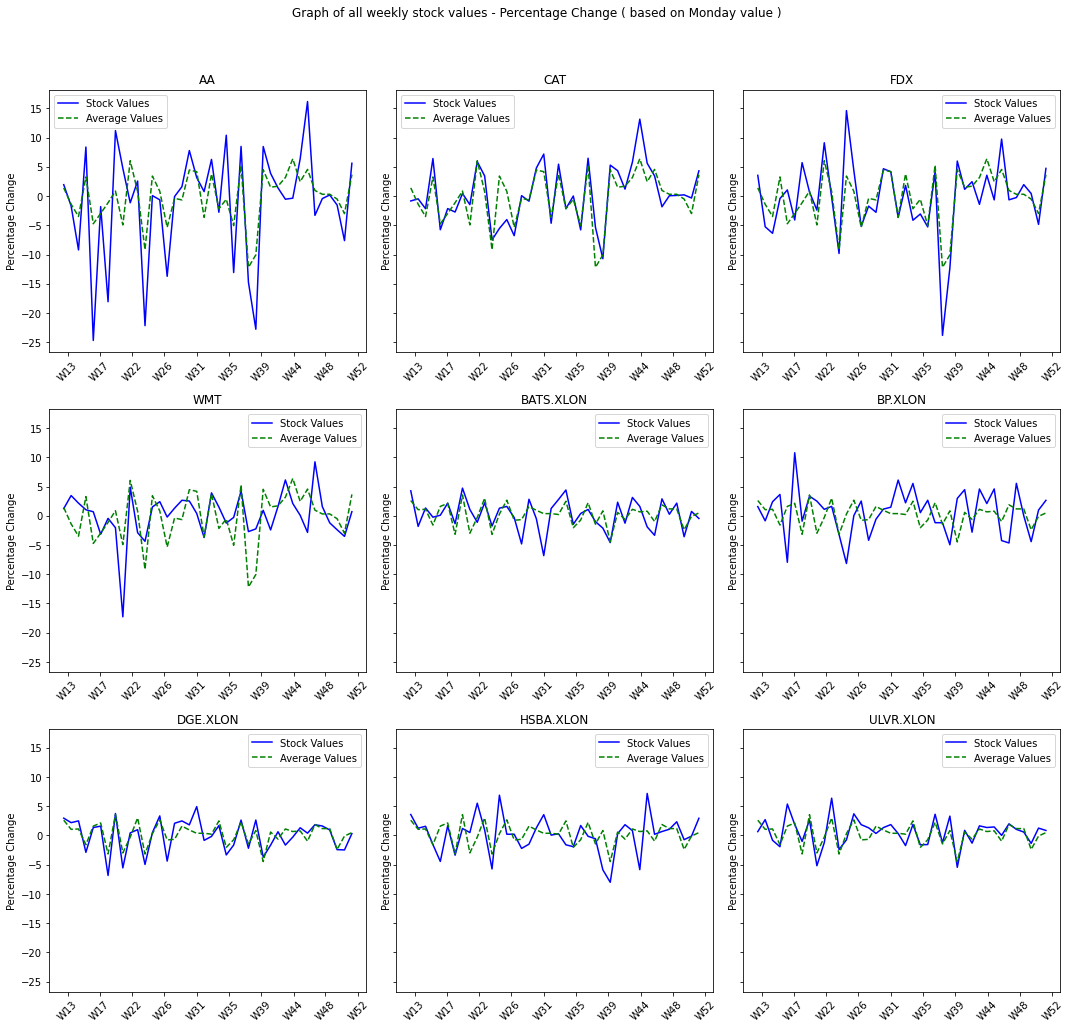

In [77]:
# Read in the data from the WeeklyClosingData file
ClosingOnlyWeeksPCDF = pd.read_csv  ('../Data/weeklyClosingDataMonday.csv', parse_dates=(['Time']), index_col=['Time'] )
ClosingOnlyWeeksPCDF.info()
ClosingOnlyWeeksPCDF.head(20)

# List of NYSE stock exchange symbols (note one symbol is missing )
NYSE = ['AA','CAT','FDX','WMT']

# List of LSD stock exchange symbols 
LSE = ['BATS.XLON','BP.XLON','DGE.XLON','HSBA.XLON','ULVR.XLON']

# setup a date format of year and week number
xfmt = mdates.DateFormatter('W%V')

# Set the canvas size so the plots can be seen
plt.rcParams['figure.figsize'] = [15, 15]

# create a series of nine plots (3x3) containing the normalised data for the stocks over the time period
fig, ax = plt.subplots(3, 3, sharey=True)

# Create a dataframe with the closing data from the two exchanges only
DFForPlotting = pd.merge (ClosingOnlyWeeksPCDF[NYSE], ClosingOnlyWeeksPCDF[LSE], left_index=True, right_index=True )
DFForPlotting.head(10)

# Iterate through the stocks symbols
for (index, columnName) in enumerate (DFForPlotting):

    row = 0
    col = 0
    if ( index <= 2 ):
        
        # row is 0 (first row) and col is the index
        row = 0
        col = index
    elif ( index <=5 ):
        # Row is 1 (second row). Col is reduced by 3 as this is the second row and index 3 -> 0, 
        # index 4 -> 1 and index 5 -> 2 etc.
        row = 1
        col = index - 3
    else:
        # Row is 2 (third row). Col is reduced by 6 as this is the second row and index 6 -> 0, 
        # index 7 -> 1 and index 8 -> 2 etc.
        row = 2
        col = index -6

    # determine the average column, use NYSE for new york stocks and LSE for london stocks
    avgColumn = ''
    if ( columnName in NYSE ): avgColumn = 'NYSE'
    if ( columnName in LSE ):  avgColumn = 'LSE'
        
    # plot the weekly data column in to the row and column of the axis
    ax[row,col].plot(DFForPlotting.index, DFForPlotting[columnName], color="blue", label ='Stock Values')
    
    # If we have an average column
    if ( avgColumn != '' ): ax[row,col].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF[avgColumn], color="green", linestyle='--' , label ='Average Values')
    
    # set the title of the subplot as the name of column which is the stock ticker symbol
    ax[row,col].set_title ( columnName )
    
    # set the Y axis title as "percentage change"
    ax[row,col].set_ylabel("Percentage Change")

    # set the date format for the xaxis and the rotation 
    ax[row,col].xaxis.set_major_formatter(xfmt)
    ax[row,col].xaxis.set_tick_params(rotation=45)
    
    # set the legend
    ax[row,col].legend()

# set the title of the overall plot
fig.suptitle ("Graph of all weekly stock values - Percentage Change ( based on Monday value )")

# Specify that we use a tight layout and reduce the area slightly to have a better fit
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the figure
fig.savefig('../image/report1.png', facecolor='white')
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2022-03-27 to 2023-01-01
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AA         40 non-null     float64
 1   BATS.XLON  40 non-null     float64
 2   BP.XLON    40 non-null     float64
 3   CAT        40 non-null     float64
 4   DGE.XLON   40 non-null     float64
 5   FDX        40 non-null     float64
 6   HSBA.XLON  40 non-null     float64
 7   ULVR.XLON  40 non-null     float64
 8   WMT        40 non-null     float64
 9   NYSE       40 non-null     float64
 10  LSE        40 non-null     float64
 11  NYSEQ1     40 non-null     float64
 12  LSEQ1      40 non-null     float64
 13  NYSEQ3     40 non-null     float64
 14  LSEQ3      40 non-null     float64
 15  USA_GDP    40 non-null     float64
 16  GBR_GDP    40 non-null     float64
dtypes: float64(17)
memory usage: 5.8 KB


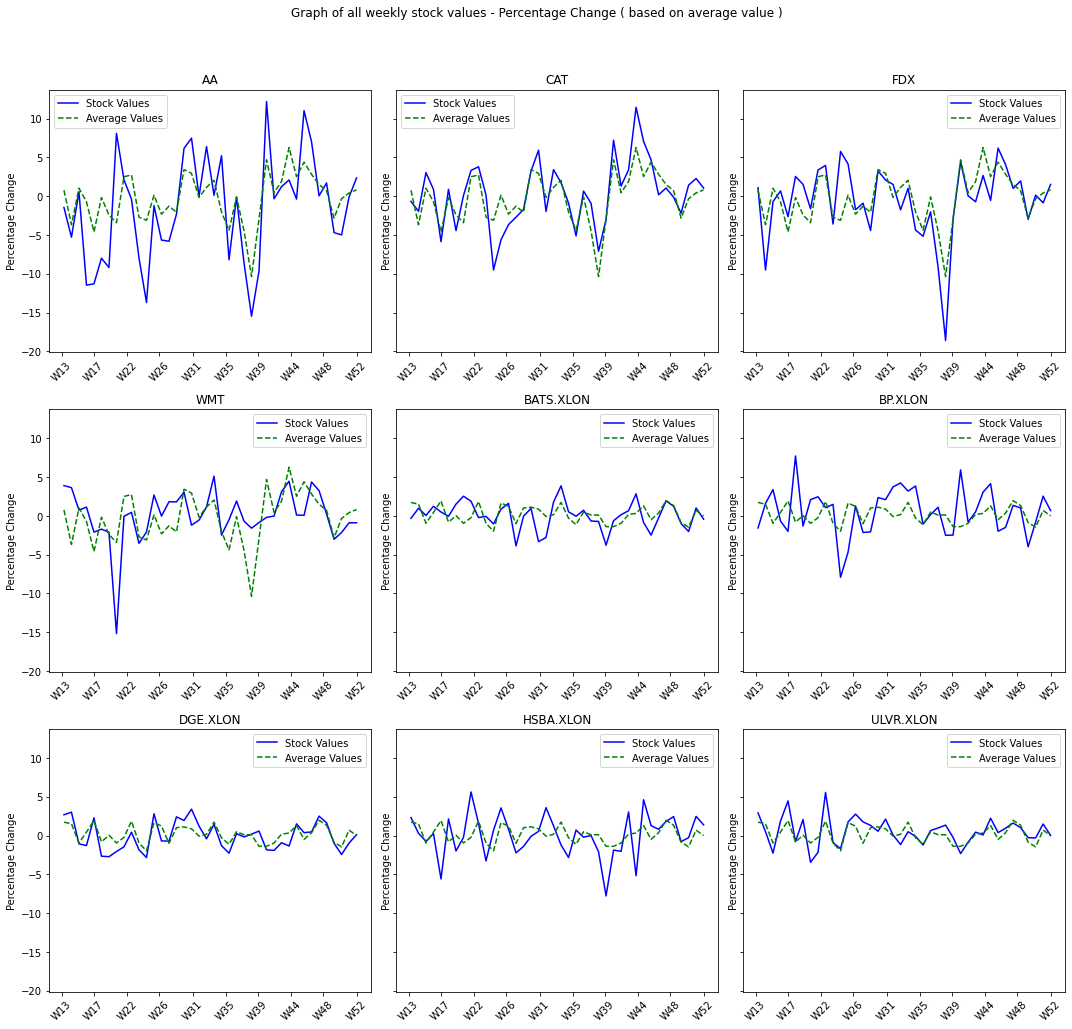

In [25]:
# Read in the data from the WeeklyClosingData file
ClosingOnlyWeeksPCDF = pd.read_csv  ('../Data/weeklyClosingDataAverage.csv', parse_dates=(['Time']), index_col=['Time'] )
ClosingOnlyWeeksPCDF.info()
ClosingOnlyWeeksPCDF.head(20)

# setup a date format of year and week number
xfmt = mdates.DateFormatter('W%V')

# create a series of nine plots (3x3) containing the normalised data for the stocks over the time period
fig, ax = plt.subplots(3, 3, sharey=True)

# Create a dataframe with the closing data from the two exchanges only
DFForPlotting = pd.merge (ClosingOnlyWeeksPCDF[NYSE], ClosingOnlyWeeksPCDF[LSE], left_index=True, right_index=True )
DFForPlotting.head(10)

# Iterate through the stocks symbols
for (index, columnName) in enumerate (DFForPlotting):

    row = 0
    col = 0
    if ( index <= 2 ):
        
        # row is 0 (first row) and col is the index
        row = 0
        col = index
    elif ( index <=5 ):
        # Row is 1 (second row). Col is reduced by 3 as this is the second row and index 3 -> 0, 
        # index 4 -> 1 and index 5 -> 2 etc.
        row = 1
        col = index - 3
    else:
        # Row is 2 (third row). Col is reduced by 6 as this is the second row and index 6 -> 0, 
        # index 7 -> 1 and index 8 -> 2 etc.
        row = 2
        col = index -6

    # determine the average column, use NYSE for new york sotcks and LSE for london stocks
    avgColumn = ''
    if ( columnName in NYSE ): avgColumn = 'NYSE'
    if ( columnName in LSE ):  avgColumn = 'LSE'
        
    # plot the weekly data column in to the row and column of the axis
    ax[row,col].plot(DFForPlotting.index, DFForPlotting[columnName], color="blue", label ='Stock Values')
    
    # If we have an average column
    if ( avgColumn != '' ): ax[row,col].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF[avgColumn], color="green", linestyle='--' , label ='Average Values')
    
    # set the title of the subplot as the name of column which is the stock ticker symbol
    ax[row,col].set_title ( columnName )
    
    # set the Y axis title as "percentage change"
    ax[row,col].set_ylabel("Percentage Change")

    # set the date format for the xaxis and the rotation 
    ax[row,col].xaxis.set_major_formatter(xfmt)
    ax[row,col].xaxis.set_tick_params(rotation=45)
    
    # set the legend
    ax[row,col].legend()

# set the title of the overall plot
fig.suptitle ("Graph of all weekly stock values - Percentage Change ( based on average value )")

# Specify that we use a tight layout and reduce the area slightly to have a better fit
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the figure
fig.savefig('../image/report2.png', facecolor='white')
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2022-03-27 to 2023-01-01
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AA         40 non-null     float64
 1   BATS.XLON  40 non-null     float64
 2   BP.XLON    40 non-null     float64
 3   CAT        40 non-null     float64
 4   DGE.XLON   40 non-null     float64
 5   FDX        40 non-null     float64
 6   HSBA.XLON  40 non-null     float64
 7   ULVR.XLON  40 non-null     float64
 8   WMT        40 non-null     float64
 9   NYSE       40 non-null     float64
 10  LSE        40 non-null     float64
 11  NYSEQ1     40 non-null     float64
 12  LSEQ1      40 non-null     float64
 13  NYSEQ3     40 non-null     float64
 14  LSEQ3      40 non-null     float64
 15  USA_GDP    40 non-null     float64
 16  GBR_GDP    40 non-null     float64
dtypes: float64(17)
memory usage: 5.8 KB


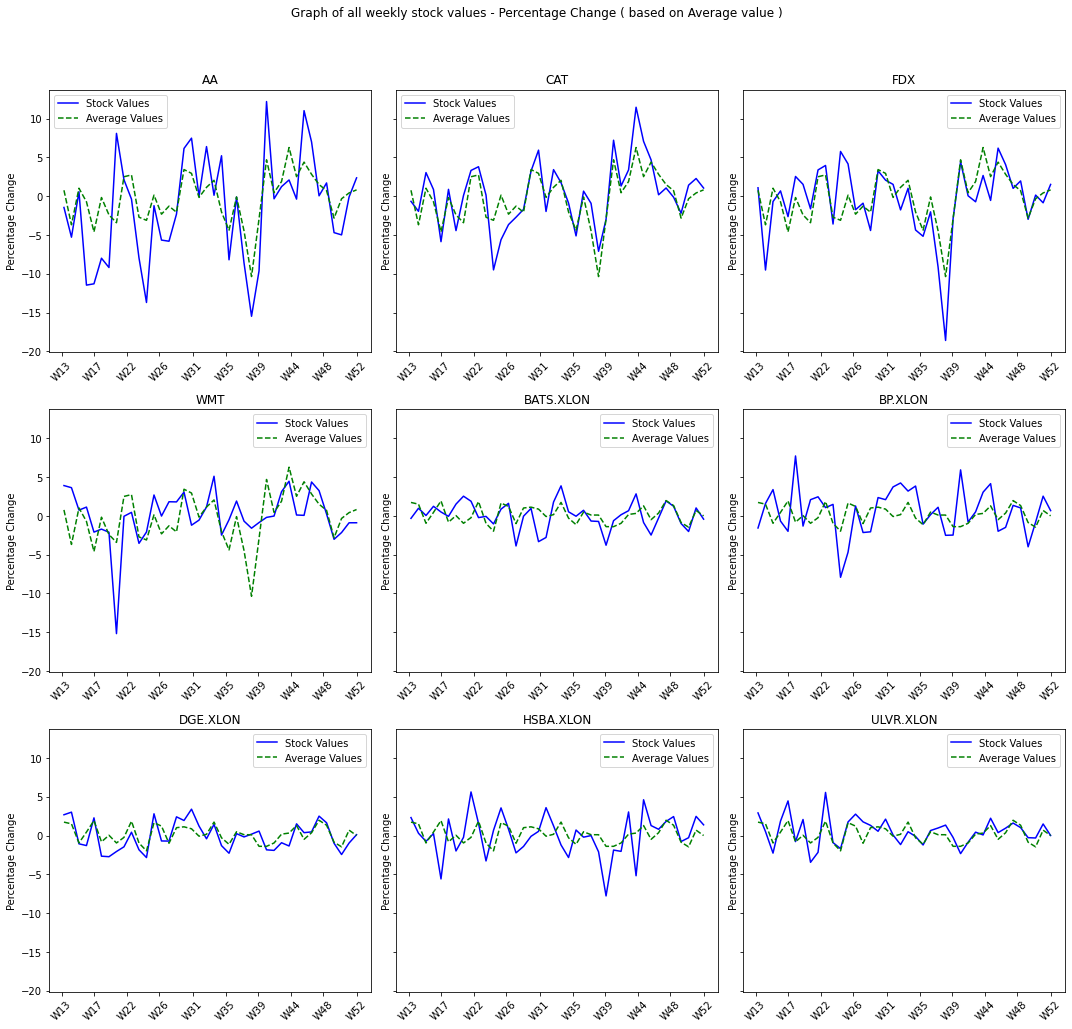

In [78]:
# Read in the data from the WeeklyClosingData file
ClosingOnlyWeeksPCDF = pd.read_csv  ('../Data/weeklyClosingDataAverage.csv', parse_dates=(['Time']), index_col=['Time'] )
ClosingOnlyWeeksPCDF.info()
ClosingOnlyWeeksPCDF.head(20)

# List of NYSE stock exchange symbols (note one symbol is missing )
NYSE = ['AA','CAT','FDX','WMT']

# List of LSD stock exchange symbols 
LSE = ['BATS.XLON','BP.XLON','DGE.XLON','HSBA.XLON','ULVR.XLON']

# setup a date format of year and week number
xfmt = mdates.DateFormatter('W%V')

# Set the canvas size so the plots can be seen
plt.rcParams['figure.figsize'] = [15, 15]

# create a series of nine plots (3x3) containing the normalised data for the stocks over the time period
fig, ax = plt.subplots(3, 3, sharey=True)

# Create a dataframe with the closing data from the two exchanges only
DFForPlotting = pd.merge (ClosingOnlyWeeksPCDF[NYSE], ClosingOnlyWeeksPCDF[LSE], left_index=True, right_index=True )
DFForPlotting.head(10)

# Iterate through the stocks symbols
for (index, columnName) in enumerate (DFForPlotting):

    row = 0
    col = 0
    if ( index <= 2 ):
        
        # row is 0 (first row) and col is the index
        row = 0
        col = index
    elif ( index <=5 ):
        # Row is 1 (second row). Col is reduced by 3 as this is the second row and index 3 -> 0, 
        # index 4 -> 1 and index 5 -> 2 etc.
        row = 1
        col = index - 3
    else:
        # Row is 2 (third row). Col is reduced by 6 as this is the second row and index 6 -> 0, 
        # index 7 -> 1 and index 8 -> 2 etc.
        row = 2
        col = index -6

    # determine the average column, use NYSE for new york stocks and LSE for london stocks
    avgColumn = ''
    if ( columnName in NYSE ): avgColumn = 'NYSE'
    if ( columnName in LSE ):  avgColumn = 'LSE'
        
    # plot the weekly data column in to the row and column of the axis
    ax[row,col].plot(DFForPlotting.index, DFForPlotting[columnName], color="blue", label ='Stock Values')
    
    # If we have an average column
    if ( avgColumn != '' ): ax[row,col].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF[avgColumn], color="green", linestyle='--' , label ='Average Values')
    
    # set the title of the subplot as the name of column which is the stock ticker symbol
    ax[row,col].set_title ( columnName )
    
    # set the Y axis title as "percentage change"
    ax[row,col].set_ylabel("Percentage Change")

    # set the date format for the xaxis and the rotation 
    ax[row,col].xaxis.set_major_formatter(xfmt)
    ax[row,col].xaxis.set_tick_params(rotation=45)
    
    # set the legend
    ax[row,col].legend()

# set the title of the overall plot
fig.suptitle ("Graph of all weekly stock values - Percentage Change ( based on Average value )")

# Specify that we use a tight layout and reduce the area slightly to have a better fit
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the figure
fig.savefig('../image/report2.png', facecolor='white')
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2022-03-21 to 2022-12-26
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AA         40 non-null     float64
 1   BATS.XLON  40 non-null     float64
 2   BP.XLON    40 non-null     float64
 3   CAT        40 non-null     float64
 4   DGE.XLON   40 non-null     float64
 5   FDX        40 non-null     float64
 6   HSBA.XLON  40 non-null     float64
 7   ULVR.XLON  40 non-null     float64
 8   WMT        40 non-null     float64
 9   NYSE       40 non-null     float64
 10  LSE        40 non-null     float64
 11  NYSEQ1     40 non-null     float64
 12  LSEQ1      40 non-null     float64
 13  NYSEQ3     40 non-null     float64
 14  LSEQ3      40 non-null     float64
 15  USA_GDP    40 non-null     float64
 16  GBR_GDP    40 non-null     float64
dtypes: float64(17)
memory usage: 5.8 KB


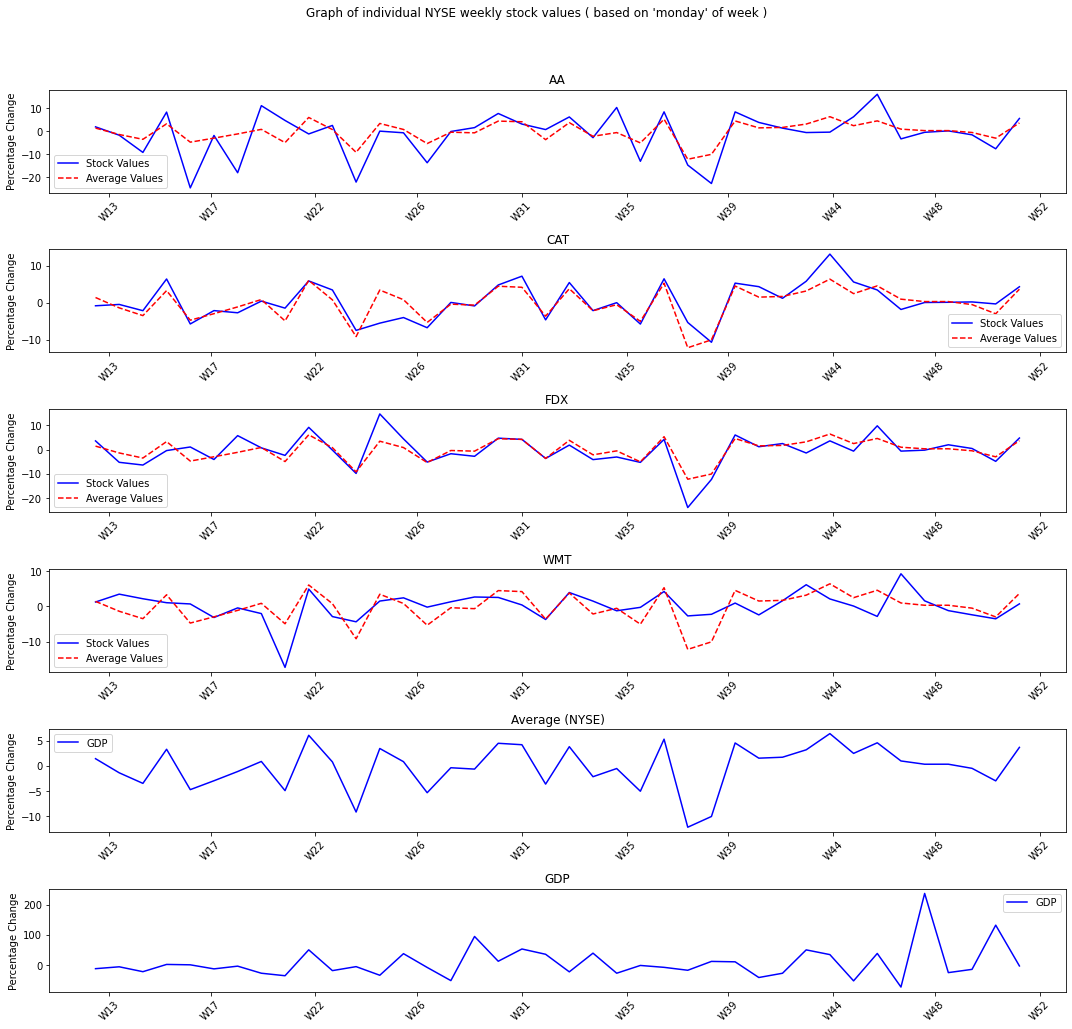

In [79]:
""" --------------------------------------------------------------------------------------------------------

File:		Create report on All Stock Exchange data for NYSE and the GDP for comparison
Author:		Brian McCarthy (brian.mccarthy@hpo.ie)
Create:		2023-03-27
Descr		The purpose of this script is to report on the four stock exchange values
            from the new york stock exchange and to show the USA GDP figures for comparison

""" 

# import the Python Libraries
import pandas as pd	              # library for pandas
import matplotlib.pyplot as plt   # library for plotting
import matplotlib.dates as mdates # library for dates 

# Read in the data from the WeeklyClosingData file
ClosingOnlyWeeksPCDF = pd.read_csv  ('../Data/weeklyClosingDataMonday.csv', parse_dates=(['Time']), index_col=['Time'] )
ClosingOnlyWeeksPCDF.info()
ClosingOnlyWeeksPCDF.head(20)

# setup a date format of year and week number
xfmt = mdates.DateFormatter('W%V')

# Create a dataframe containing the new york data only
DFForPlotting = ClosingOnlyWeeksPCDF[NYSE]
DFForPlotting.head(10)

# create a series of plots (5) 
fig, ax = plt.subplots(6, 1, sharey=False)

# Iterate through the stocks symbols
for (index, columnName) in enumerate (DFForPlotting):

    ax[index].plot(DFForPlotting.index, DFForPlotting[columnName], color="blue", label="Stock Values")
    ax[index].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF['NYSE'], color="red", label="Average Values", linestyle='--')

    # set the title of the subplot as the name of column which is the stock ticker symbol
    ax[index].set_title ( columnName )
    
    # set the Y axis title as "percentage change"
    ax[index].set_ylabel("Percentage Change")

    # set the date format for the xaxis and the rotation 
    ax[index].xaxis.set_major_formatter(xfmt)
    ax[index].xaxis.set_tick_params(rotation=45)
    
    # set the legend
    ax[index].legend()

# include the average graph as number 4 
ax[4].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF['NYSE'], color="blue", label="GDP")
ax[4].set_title ('Average (NYSE)')
ax[4].set_ylabel("Percentage Change")
ax[4].xaxis.set_major_formatter(xfmt)
ax[4].xaxis.set_tick_params(rotation=45)
ax[4].legend()

# include the GDP graph as number 5
ax[5].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF['USA_GDP'], color="blue", label="GDP")
ax[5].set_title ('GDP')
ax[5].set_ylabel("Percentage Change")
ax[5].xaxis.set_major_formatter(xfmt)
ax[5].xaxis.set_tick_params(rotation=45)
ax[5].legend()
   
    
# set the title
fig.suptitle ("Graph of individual NYSE weekly stock values ( based on 'monday' of week )")
    
# Specify that we use a tight layout and reduce the area slightly to have a better fit
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the figure
fig.savefig('../image/report3.png', facecolor='white')
plt.show()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2022-03-21 to 2022-12-26
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AA         40 non-null     float64
 1   BATS.XLON  40 non-null     float64
 2   BP.XLON    40 non-null     float64
 3   CAT        40 non-null     float64
 4   DGE.XLON   40 non-null     float64
 5   FDX        40 non-null     float64
 6   HSBA.XLON  40 non-null     float64
 7   ULVR.XLON  40 non-null     float64
 8   WMT        40 non-null     float64
 9   NYSE       40 non-null     float64
 10  LSE        40 non-null     float64
 11  NYSEQ1     40 non-null     float64
 12  LSEQ1      40 non-null     float64
 13  NYSEQ3     40 non-null     float64
 14  LSEQ3      40 non-null     float64
 15  USA_GDP    40 non-null     float64
 16  GBR_GDP    40 non-null     float64
dtypes: float64(17)
memory usage: 5.8 KB


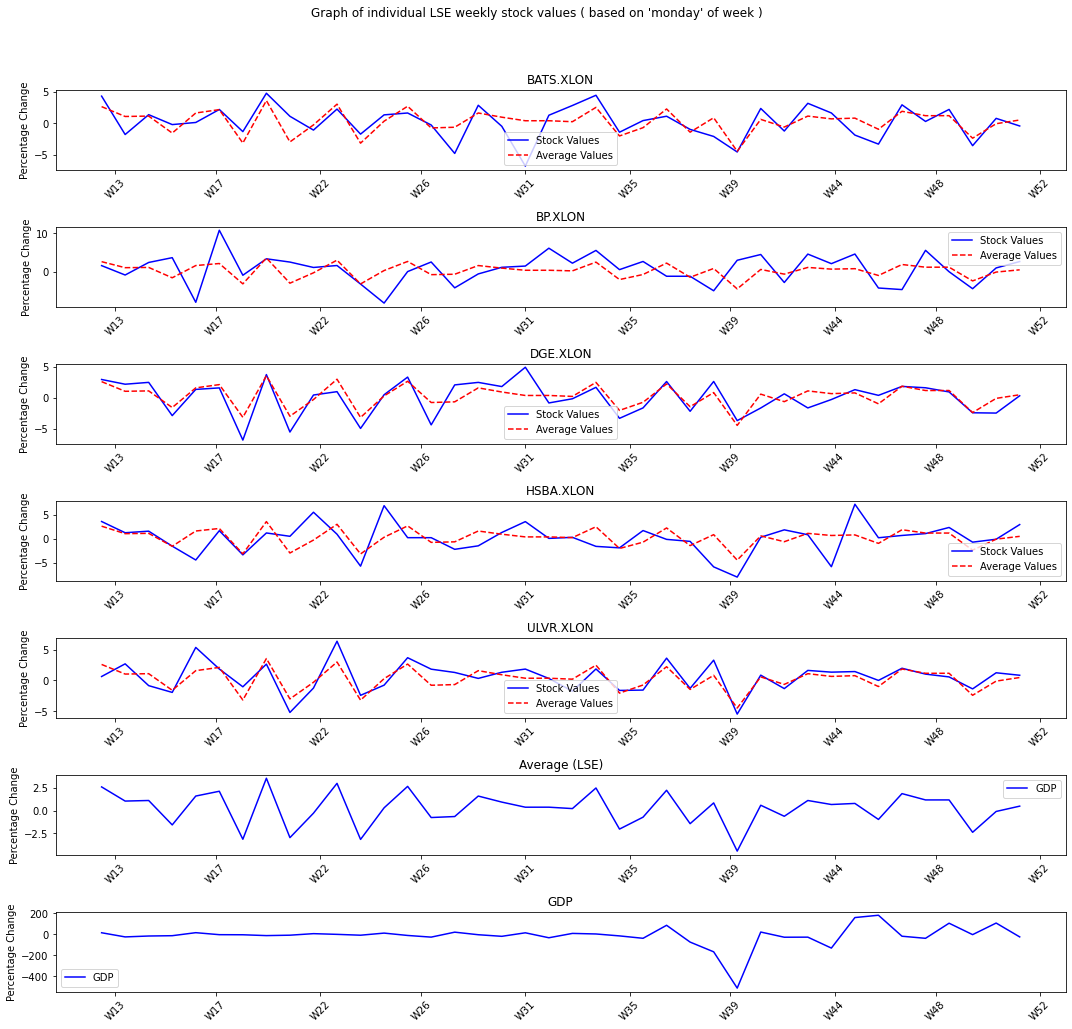

In [80]:
# Read in the data from the WeeklyClosingData file
ClosingOnlyWeeksPCDF = pd.read_csv  ('../Data/weeklyClosingDataMonday.csv', parse_dates=(['Time']), index_col=['Time'] )
ClosingOnlyWeeksPCDF.info()
ClosingOnlyWeeksPCDF.head(20)

# setup a date format of year and week number
xfmt = mdates.DateFormatter('W%V')

# Create a dataframe containing the london data only
DFForPlotting = ClosingOnlyWeeksPCDF[LSE]
DFForPlotting.head(10)

# create a series of plots (7) 
fig, ax = plt.subplots(7, 1, sharey=False)

# Iterate through the stocks symbols
for (index, columnName) in enumerate (DFForPlotting):

    ax[index].plot(DFForPlotting.index, DFForPlotting[columnName], color="blue", label="Stock Values")
    ax[index].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF['LSE'], color="red", label="Average Values", linestyle='--')

    # set the title of the subplot as the name of column which is the stock ticker symbol
    ax[index].set_title ( columnName )
    
    # set the Y axis title as "percentage change"
    ax[index].set_ylabel("Percentage Change")

    # set the date format for the xaxis and the rotation 
    ax[index].xaxis.set_major_formatter(xfmt)
    ax[index].xaxis.set_tick_params(rotation=45)
    
    # set the legend
    ax[index].legend()
    
# include the average graph as number 5 
ax[5].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF['LSE'], color="blue", label="GDP")
ax[5].set_title ('Average (LSE)')
ax[5].set_ylabel("Percentage Change")
ax[5].xaxis.set_major_formatter(xfmt)
ax[5].xaxis.set_tick_params(rotation=45)
ax[5].legend()

# include the GDP graph as number 6 
ax[6].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF['GBR_GDP'], color="blue", label="GDP")
ax[6].set_title ('GDP')
ax[6].set_ylabel("Percentage Change")
ax[6].xaxis.set_major_formatter(xfmt)
ax[6].xaxis.set_tick_params(rotation=45)
ax[6].legend()
    
# set the title
fig.suptitle ("Graph of individual LSE weekly stock values ( based on 'monday' of week )")
    
# Specify that we use a tight layout and reduce the area slightly to have a better fit
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the figure
fig.savefig('../image/report4.png', facecolor='white')
plt.show()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2022-03-21 to 2022-12-26
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AA         40 non-null     float64
 1   BATS.XLON  40 non-null     float64
 2   BP.XLON    40 non-null     float64
 3   CAT        40 non-null     float64
 4   DGE.XLON   40 non-null     float64
 5   FDX        40 non-null     float64
 6   HSBA.XLON  40 non-null     float64
 7   ULVR.XLON  40 non-null     float64
 8   WMT        40 non-null     float64
 9   NYSE       40 non-null     float64
 10  LSE        40 non-null     float64
 11  NYSEQ1     40 non-null     float64
 12  LSEQ1      40 non-null     float64
 13  NYSEQ3     40 non-null     float64
 14  LSEQ3      40 non-null     float64
 15  USA_GDP    40 non-null     float64
 16  GBR_GDP    40 non-null     float64
dtypes: float64(17)
memory usage: 5.8 KB
Time
2022-09-26   -168.914431
2022-10-03   -514.849722
2022-10-31   -133.307

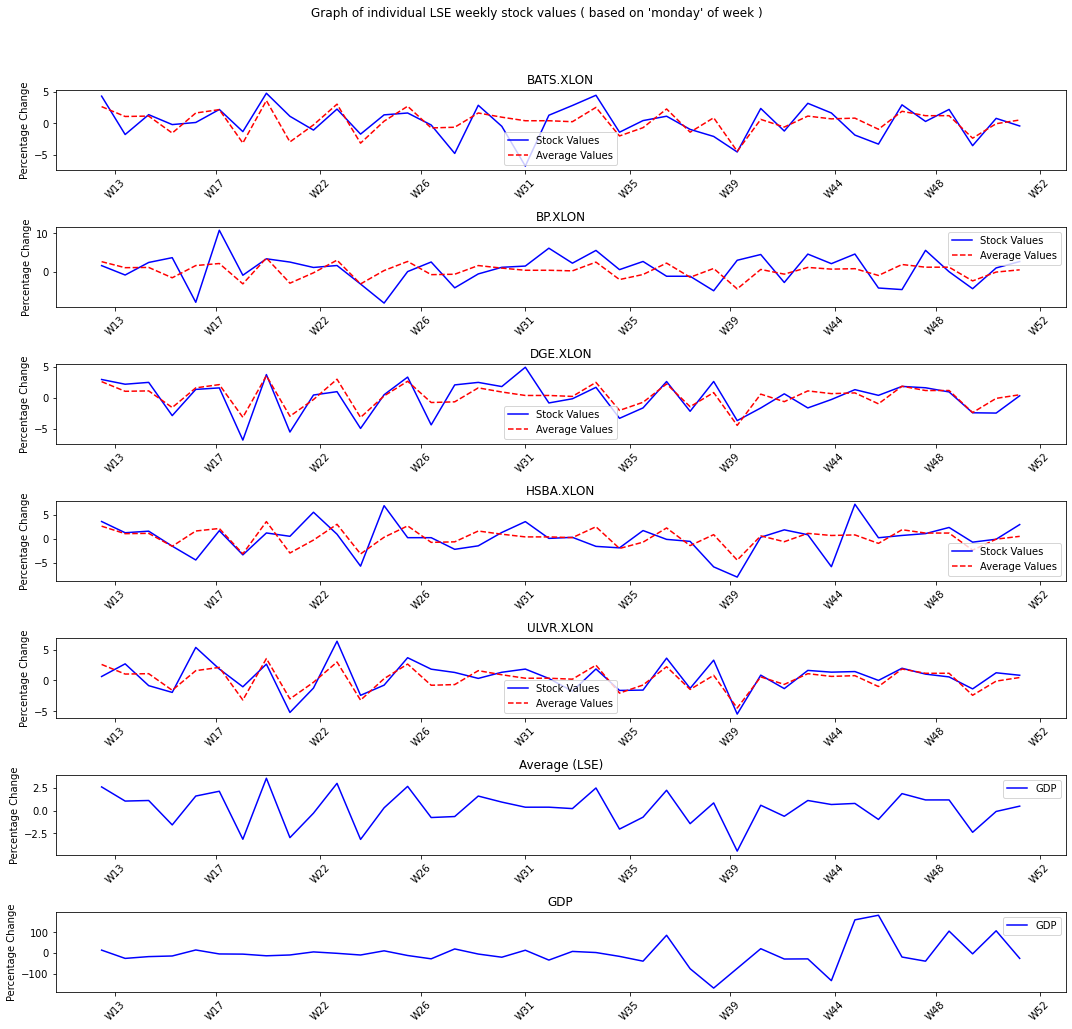

In [81]:
# Read in the data from the WeeklyClosingDataMonday file
ClosingOnlyWeeksPCDF = pd.read_csv  ('../Data/weeklyClosingDataMonday.csv', parse_dates=(['Time']), index_col=['Time'] )
ClosingOnlyWeeksPCDF.info()
ClosingOnlyWeeksPCDF.head(20)

# setup a date format of year and week number
xfmt = mdates.DateFormatter('W%V')

# Create a dataframe containing the london data only
DFForPlotting = ClosingOnlyWeeksPCDF[LSE]
DFForPlotting.head(10)

# create a series of plots (7)
fig, ax = plt.subplots(7, 1, sharey=False)

# Iterate through the stocks symbols
for (index, columnName) in enumerate (DFForPlotting):

    ax[index].plot(DFForPlotting.index, DFForPlotting[columnName], color="blue", label="Stock Values")
    ax[index].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF['LSE'], color="red", label="Average Values", linestyle='--')

    # set the title of the subplot as the name of column which is the stock ticker symbol
    ax[index].set_title ( columnName )
    
    # set the Y axis title as "percentage change"
    ax[index].set_ylabel("Percentage Change")

    # set the date format for the xaxis and the rotation 
    ax[index].xaxis.set_major_formatter(xfmt)
    ax[index].xaxis.set_tick_params(rotation=45)
    
    # set the legend
    ax[index].legend()
    
# include the average graph as number 5 
ax[5].plot(ClosingOnlyWeeksPCDF.index, ClosingOnlyWeeksPCDF['LSE'], color="blue", label="GDP")
ax[5].set_title ('Average (LSE)')
ax[5].set_ylabel("Percentage Change")
ax[5].xaxis.set_major_formatter(xfmt)
ax[5].xaxis.set_tick_params(rotation=45)
ax[5].legend()

# Display all records which are outside the range of -100 to 100
print (ClosingOnlyWeeksPCDF[(ClosingOnlyWeeksPCDF['GBR_GDP'] < -100) | (ClosingOnlyWeeksPCDF['GBR_GDP'] > 100)]['GBR_GDP'].head(20))

# remove outliers which are outside the range of -300 to +300
DFForPlotting = ClosingOnlyWeeksPCDF[(ClosingOnlyWeeksPCDF['GBR_GDP'] > -300) & (ClosingOnlyWeeksPCDF['GBR_GDP'] < 300)]
weeks = pd.date_range (freq="W-MON", start=closingOnlyDF.index.min(), end=closingOnlyDF.index.max())
DFForPlotting = pd.DataFrame(DFForPlotting.reindex(weeks))
DFForPlotting = DFForPlotting.interpolate(method='linear')

# include the revised GDP graph as number 6 
ax[6].plot(DFForPlotting.index, DFForPlotting['GBR_GDP'], color="blue", label="GDP")
ax[6].set_title ('GDP')
ax[6].set_ylabel("Percentage Change")
ax[6].xaxis.set_major_formatter(xfmt)
ax[6].xaxis.set_tick_params(rotation=45)
ax[6].legend()
    
# set the title
fig.suptitle ("Graph of individual LSE weekly stock values ( based on 'monday' of week )")
    
# Specify that we use a tight layout and reduce the area slightly to have a better fit
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the figure
fig.savefig('../image/report5.png', facecolor='white')
plt.show()


In [82]:
# Read in the data from the closingData file
closingOnlyDF = pd.read_csv  ('../Data/closingDataGDP.csv', parse_dates=(['Time']), index_col=['Time'] )

# List of NYSE stock exchange symbols (note one symbol is missing )
NYSE = ['AA','CAT','FDX','WMT']

NYSE.append('NYSE')
NYSE.append('USA_GDP')
print (closingOnlyDF[NYSE].corr())

# List of LSE stock exchange symbols 
LSE = ['BATS.XLON','BP.XLON','DGE.XLON','HSBA.XLON','ULVR.XLON']

LSE.append('LSE')
LSE.append('GBR_GDP')
print (closingOnlyDF[LSE].corr())

               AA       CAT       FDX       WMT      NYSE   USA_GDP
AA       1.000000  0.406390  0.463411  0.433827  0.848398  0.709886
CAT      0.406390  1.000000 -0.126605  0.635860  0.641201  0.086547
FDX      0.463411 -0.126605  1.000000 -0.268344  0.601224  0.321562
WMT      0.433827  0.635860 -0.268344  1.000000  0.484845  0.362934
NYSE     0.848398  0.641201  0.601224  0.484845  1.000000  0.519335
USA_GDP  0.709886  0.086547  0.321562  0.362934  0.519335  1.000000
           BATS.XLON   BP.XLON  DGE.XLON  HSBA.XLON  ULVR.XLON       LSE  \
BATS.XLON   1.000000 -0.013061 -0.375256   0.336928  -0.034408  0.188822   
BP.XLON    -0.013061  1.000000 -0.195627  -0.493499   0.682360  0.567731   
DGE.XLON   -0.375256 -0.195627  1.000000   0.266007  -0.116340  0.253015   
HSBA.XLON   0.336928 -0.493499  0.266007   1.000000  -0.246966  0.075176   
ULVR.XLON  -0.034408  0.682360 -0.116340  -0.246966   1.000000  0.848345   
LSE         0.188822  0.567731  0.253015   0.075176   0.848345  1.00